# 高级自动微分
重点介绍 tf.GradientTape API 更深入、更不常见的功能。

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 6)


## 控制梯度记录
在自动微分指南中，您已了解构建梯度计算时如何控制条带监视变量和张量。<br><br>

条带还具有操作记录的方法。<br><br>

如果您希望停止记录梯度，可以使用 GradientTape.stop_recording() 暂时挂起记录。<br><br>

---

In [4]:
x=tf.Variable(2.0)
y=tf.Variable(3.0)
with tf.GradientTape() as t:
    x_sq=x*x
    with t.stop_recording() :
        y_sq=y*y
    z=x_sq+y_sq
grad = t.gradient(z,{'x':x,'y':y})
print('dz_dx:',grad['x'].numpy())
print('dz_dy:',grad['y'])

dz_dx: 4.0
dz_dy: None


如果您希望完全重新开始，请使用 reset()。通常，直接退出梯度带块并重新开始比较易于读取，但在退出梯度带块有困难或不可行时，可以使用 reset。

In [5]:
x = tf.Variable(2.0)
y = tf.Variable(3.0)
reset = True

with tf.GradientTape() as t:
  y_sq = y * y
  if reset:
    # Throw out all the tape recorded so far
    t.reset()
  z = x * x + y_sq

grad = t.gradient(z, {'x': x, 'y': y})

print('dz/dx:', grad['x'])  # 2*x => 4
print('dz/dy:', grad['y'])


dz/dx: tf.Tensor(4.0, shape=(), dtype=float32)
dz/dy: None


## 停止梯度
与上面的全局条带控制相比，tf.stop_gradient 函数更加精确。
<br><br>
它可以用来**阻止梯度沿着特定路径流动，而不需要访问条带本身**

In [7]:
x = tf.Variable(2.0)
y = tf.Variable(3.0)

with tf.GradientTape() as t:
  y_sq = y**2
  z = x**2 + tf.stop_gradient(y_sq)

grad = t.gradient(z, {'x': x, 'y': y})

print('dz/dx:', grad['x'])  # 2*x => 4
print('dz/dy:', grad['y'])


dz/dx: tf.Tensor(4.0, shape=(), dtype=float32)
dz/dy: None


## 自定义梯度

    1. 正在编写的新运算没有定义的梯度。
    2. 默认计算在数值上不稳定。
    3. 您希望从前向传递缓存开销大的计算。
    4. 您想修改一个值（例如使用：tf.clip_by_value、tf.math.round）而不修改梯度。
    
对于编写新运算，您可以使用 tf.RegisterGradient 自行设置。请参阅其页面了解详细信息。（注意，梯度注册为全局，需谨慎更改。）<br><br>
对于后三种情况，可以使用 tf.custom_gradient。


In [20]:
with tf.GradientTape() as t:
    x=tf.Variable(100.0)
    y=tf.math.log(1+tf.exp(x))
grad=t.gradient(y,x)
print(grad)


tf.Tensor(nan, shape=(), dtype=float32)


In [30]:
@tf.custom_gradient
def log1pexp(x):
    e=tf.exp(x)
    def grad(upstream):
        return upstream*(1-1/(1+e))
    return tf.math.log(1 + e), grad
with tf.GradientTape() as t:
    x=tf.Variable(100000000.0)
    y=log1pexp(x)
grad=t.gradient(y,x)
print(grad)

tf.Tensor(1.0, shape=(), dtype=float32)


在举个最简单的例子来看看自定义梯度<br><br>
假设我们相对$z=x\times y$进行求导

In [36]:
@tf.custom_gradient
def my_gradient(x,y):
    z=x*y
    def grad(upstream):
        return upstream*y,upstream*x
    return z,grad
with tf.GradientTape() as t:
    x=tf.Variable(2.0)
    y=tf.Variable(3.0)
    z=my_gradient(x,y)
# print(t.gradient(z,x))
print(t.gradient(z,y))

tf.Tensor(2.0, shape=(), dtype=float32)


## 多个条带

In [39]:
x0 = tf.constant(0.0)
x1 = tf.constant(0.0)

with tf.GradientTape() as tape0, tf.GradientTape() as tape1:
  tape0.watch(x0)
  tape1.watch(x1)

  y0 = tf.math.sin(x0)
  y1 = tf.nn.sigmoid(x1)

  y = y0 + y1

  ys = tf.reduce_sum(y)
print(tape0.gradient(ys, x0).numpy())   # cos(x) => 1.0
print(tape1.gradient(ys, x1).numpy())   # sigmoid(x1)*(1-sigmoid(x1)) => 0.25


1.0
0.25


## 高阶梯度
GradientTape 上下文管理器内的运算会被记录下来，以供自动微分。如果在该上下文中计算梯度，梯度计算也会被记录。

In [51]:
x=tf.Variable(1.0)
with tf.GradientTape() as t2:
    with tf.GradientTape() as t1:
        y=x**3
    dy_dx=t1.gradient(y,x)
dy_dx2=t2.gradient(dy_dx,x)
print(dy_dx)
print(dy_dx2)


tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


当您从梯度计算标量，然后产生的标量作为第二个梯度计算的源时，“嵌套调用 GradientTape.gradient”是一种不错的模式，如以下示例所示。

In [53]:
x=tf.random.normal([7,5])
layer=tf.keras.layers.Dense(10,activation=tf.nn.relu)

with tf.GradientTape() as t2:
    
    with tf.GradientTape() as t1:
        t1.watch(x)
        y=layer(x)
        out=tf.reduce_sum(layer(x)**2)
    g1=t1.gradient(out,x)
    g1_mag=tf.norm(g1)
dg1_mag = t2.gradient(g1_mag, layer.trainable_variables)


## 雅可比矩阵
雅可比矩阵代表向量值函数的梯度。每行都包含其中一个向量元素的梯度<br><br>
**类似于 gradient**：sources 参数可以是张量或张量的容器。<br><br>
**不同于 gradient**：target 张量必须是单个张量.


(201,)
(201,)


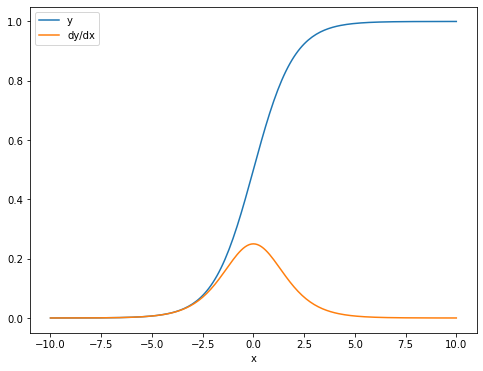

In [60]:
x=tf.linspace(-10.0,10.0,200+1)
delta=tf.Variable(0.0)
with tf.GradientTape() as t:
    y=tf.nn.sigmoid(x+delta)
dy_dx=t.jacobian(y,delta)
print(y.shape)
print(dy_dx.shape)
plt.plot(x.numpy(), y, label='y')
plt.plot(x.numpy(), dy_dx, label='dy/dx')
plt.legend()
_ = plt.xlabel('x')


In [63]:
x = tf.random.normal([7, 5])
layer = tf.keras.layers.Dense(10, activation=tf.nn.relu)

with tf.GradientTape(persistent=True) as tape:
  y = layer(x)

y.shape
layer.kernel.shape
j = tape.jacobian(y, layer.kernel)
j.shape


TensorShape([7, 10, 5, 10])